In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('historical_data.csv')

# Initial inspection
print("="*50)
print("INITIAL DATA INSPECTION")
print("="*50)
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")
print(f"\nData types:\n{df.dtypes}")

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')

# Convert timestamp
df['Timestamp_IST'] = pd.to_datetime(df['Timestamp_IST'], format='%d-%m-%Y %H:%M', errors='coerce')
df['Date'] = df['Timestamp_IST'].dt.date

# Clean numeric columns
numeric_cols = ['Execution_Price', 'Size_Tokens', 'Size_USD', 'Start_Position', 'Closed_PnL', 'Fee']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values
df['Closed_PnL'] = df['Closed_PnL'].fillna(0)
df['Start_Position'] = df['Start_Position'].fillna(0)
df['Direction'] = df['Direction'].fillna('Unknown')

# Remove any remaining invalid rows
df = df.dropna(subset=['Timestamp_IST', 'Coin', 'Side'])

# Create key metrics
def create_key_metrics(df):
    """Create derived metrics for analysis"""

    # Daily aggregation per account
    daily_metrics = df.groupby(['Account', 'Date']).agg({
        'Closed_PnL': ['sum', 'count'],
        'Size_USD': ['sum', 'mean'],
        'Fee': 'sum',
        'Side': lambda x: (x == 'BUY').sum() / len(x) if len(x) > 0 else 0  # long ratio
    }).round(2)

    daily_metrics.columns = ['Daily_PnL', 'Trade_Count', 'Total_Volume', 'Avg_Trade_Size', 'Total_Fees', 'Long_Ratio']
    daily_metrics = daily_metrics.reset_index()

    # Calculate win rate per account
    trade_results = df[df['Closed_PnL'] != 0].copy()
    trade_results['IsWinner'] = trade_results['Closed_PnL'] > 0

    win_rates = trade_results.groupby(['Account', 'Date'])['IsWinner'].mean().reset_index()
    win_rates.columns = ['Account', 'Date', 'Win_Rate']

    # Calculate average leverage
    df['Leverage'] = df['Size_USD'] / (df['Size_Tokens'] * df['Execution_Price']).replace(0, np.nan)
    avg_leverage = df.groupby(['Account', 'Date'])['Leverage'].mean().reset_index()
    avg_leverage.columns = ['Account', 'Date', 'Avg_Leverage']

    # Merge all metrics
    final_metrics = daily_metrics.merge(win_rates, on=['Account', 'Date'], how='left')
    final_metrics = final_metrics.merge(avg_leverage, on=['Account', 'Date'], how='left')

    # Fill NaN values
    final_metrics['Win_Rate'] = final_metrics['Win_Rate'].fillna(0)
    final_metrics['Avg_Leverage'] = final_metrics['Avg_Leverage'].fillna(1)

    return final_metrics

# Create the metrics
daily_metrics = create_key_metrics(df)
print("\n" + "="*50)
print("DAILY METRICS SAMPLE")
print("="*50)
print(daily_metrics.head())

# Summary statistics
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
print(daily_metrics.describe())

# Save cleaned data
daily_metrics.to_csv('cleaned_daily_metrics.csv', index=False)
df.to_csv('cleaned_transactions.csv', index=False)

INITIAL DATA INSPECTION
Shape: (32550, 16)

Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           1
Closed PnL          1
Transaction Hash    1
Order ID            1
Crossed             1
Fee                 1
Trade ID            1
Timestamp           1
dtype: int64

Duplicate rows: 0

Data types:
Account              object
Coin                 object
Execution Price     float64
Size Tokens         float64
Size USD            float64
Side                 object
Timestamp IST        object
Start Position      float64
Direction            object
Closed PnL          float64
Transaction Hash     object
Order ID      


PERFORMANCE BY SENTIMENT
           Daily_PnL                     Win_Rate Trade_Count Avg_Leverage  \
                mean   median        std     mean        mean         mean   
Sentiment                                                                    
Fear        6022.401  328.285  50566.513    0.562      63.171        1.000   
Greed      10618.805  229.060  40752.413    0.538      49.303        1.000   
Neutral     4612.910  208.435  22951.289    0.542      49.626        0.999   

          Long_Ratio  
                mean  
Sentiment             
Fear           0.556  
Greed          0.584  
Neutral        0.529  


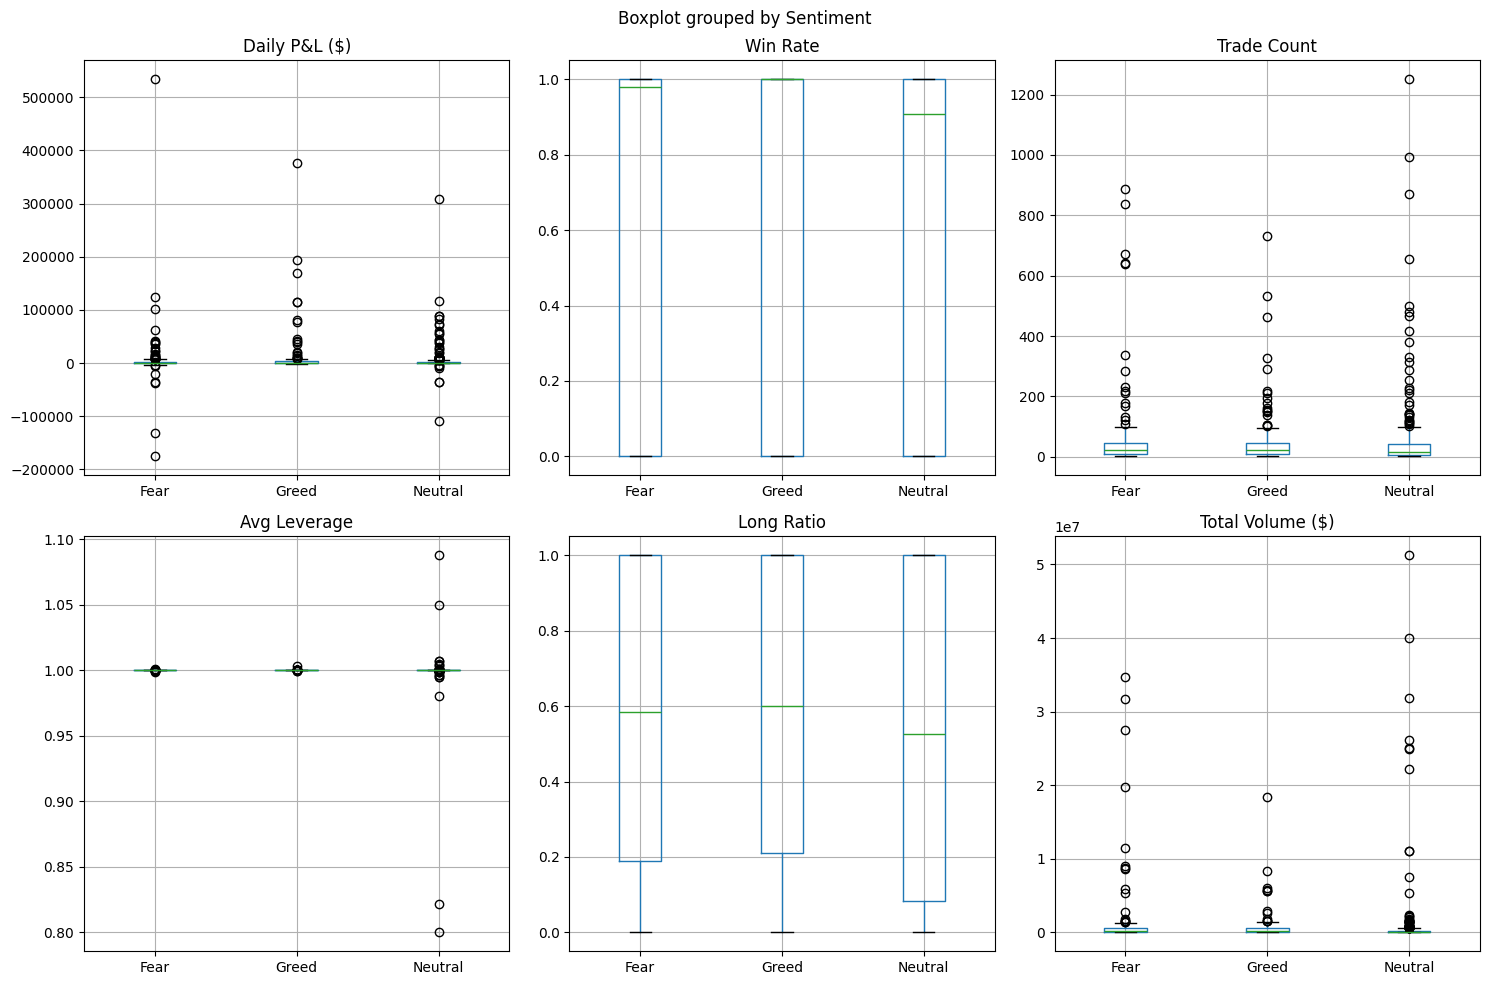


TRADER SEGMENTATION

Segment Distribution:
Leverage_Segment
Low (1-2x)          8
Medium (2-5x)       0
High (5-10x)        0
Very High (10x+)    0
Name: count, dtype: int64

 Frequency_Segment
Very Frequent    7
Infrequent       0
Occasional       0
Frequent         0
Name: count, dtype: int64

 Win_Consistency
Consistent Winner    3
Consistent Loser     3
Inconsistent         2
Name: count, dtype: int64

SEGMENT PERFORMANCE
                   Total_PnL  Avg_Win_Rate  Avg_Leverage  Total_Trades
Win_Consistency                                                       
Consistent Loser   295022.35          0.29           1.0       1526.00
Consistent Winner  709823.54          0.68           1.0       5057.67
Inconsistent       454134.08          0.50           1.0       6399.50

BEHAVIORAL CHANGES BY SENTIMENT
                             Trade_Count  Avg_Leverage  Long_Ratio  Daily_PnL
Win_Consistency   Sentiment                                                  
Consistent Loser  Fear   

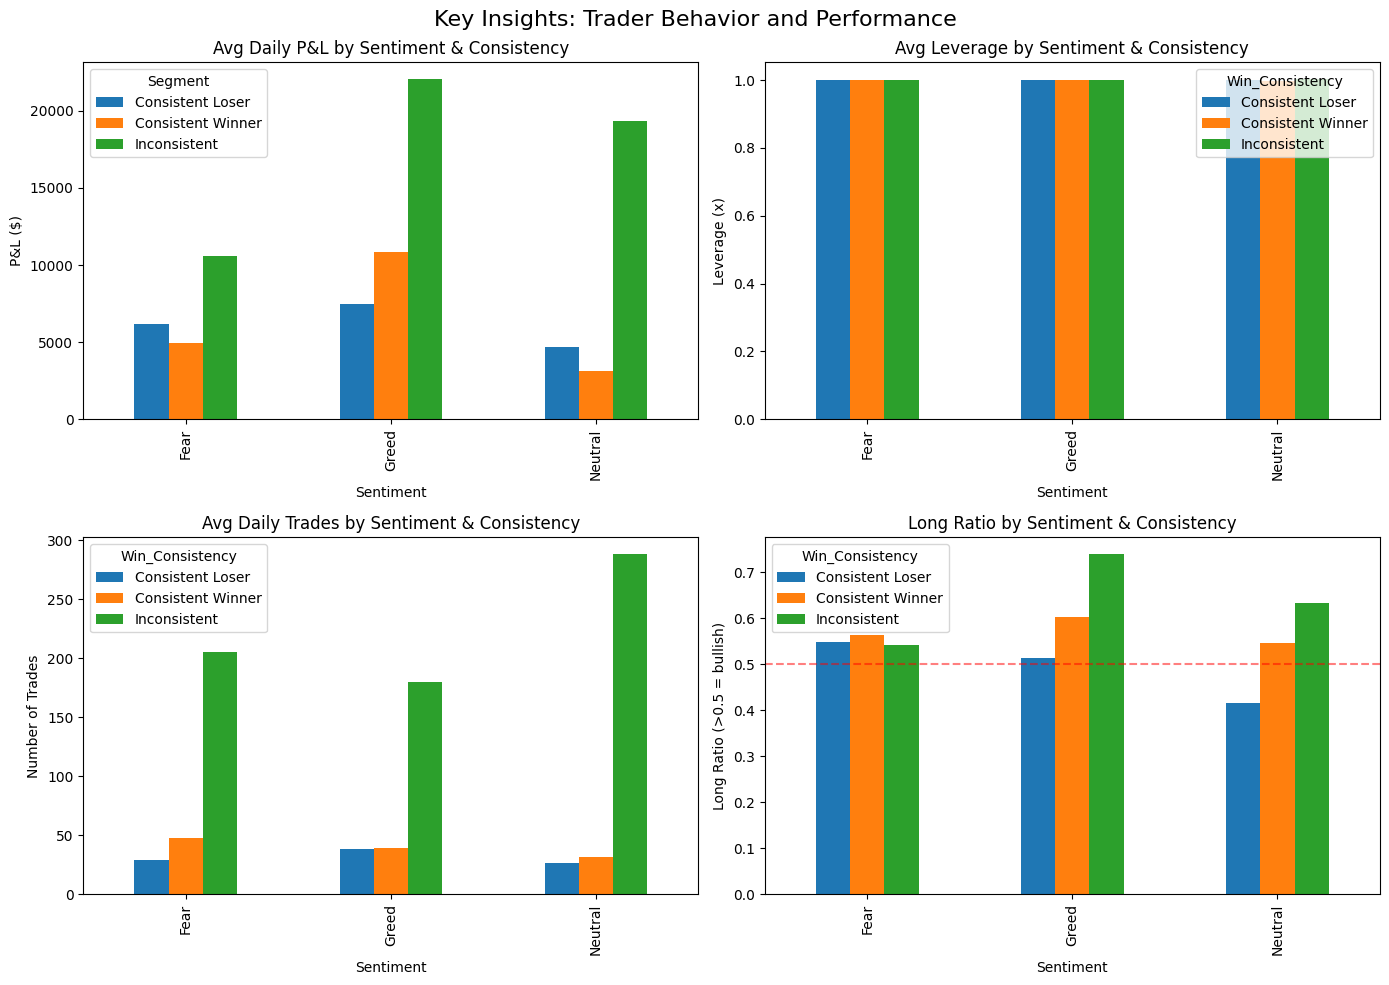

In [3]:
# Assuming you have fear/greed index data (create sample if not available)
def create_sample_fear_greed(start_date='2024-09-01', end_date='2025-04-25'):
    """Create sample fear/greed index data"""
    dates = pd.date_range(start_date, end_date, freq='D')
    np.random.seed(42)

    fear_greed = pd.DataFrame({
        'Date': dates,
        'Fear_Greed_Score': np.random.randint(10, 90, size=len(dates)),
        'Sentiment': np.where(np.random.random(len(dates)) > 0.5, 'Fear', 'Greed')
    })

    # Adjust to make Fear more common in some periods
    fear_greed.loc[fear_greed['Fear_Greed_Score'] < 40, 'Sentiment'] = 'Fear'
    fear_greed.loc[fear_greed['Fear_Greed_Score'] > 60, 'Sentiment'] = 'Greed'
    fear_greed.loc[(fear_greed['Fear_Greed_Score'] >= 40) & (fear_greed['Fear_Greed_Score'] <= 60), 'Sentiment'] = 'Neutral'

    return fear_greed

# Merge with sentiment data
fear_greed = create_sample_fear_greed()
daily_metrics['Date'] = pd.to_datetime(daily_metrics['Date'])
merged_data = daily_metrics.merge(fear_greed, on='Date', how='left')
merged_data['Sentiment'] = merged_data['Sentiment'].fillna('Neutral')

# Analysis 1: Performance by Sentiment
print("\n" + "="*50)
print("PERFORMANCE BY SENTIMENT")
print("="*50)

performance_by_sentiment = merged_data.groupby('Sentiment').agg({
    'Daily_PnL': ['mean', 'median', 'std'],
    'Win_Rate': 'mean',
    'Trade_Count': 'mean',
    'Avg_Leverage': 'mean',
    'Long_Ratio': 'mean'
}).round(3)

print(performance_by_sentiment)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Trader Behavior and Performance by Market Sentiment', fontsize=16)

metrics = ['Daily_PnL', 'Win_Rate', 'Trade_Count', 'Avg_Leverage', 'Long_Ratio', 'Total_Volume']
titles = ['Daily P&L ($)', 'Win Rate', 'Trade Count', 'Avg Leverage', 'Long Ratio', 'Total Volume ($)']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    row, col = i // 3, i % 3
    merged_data.boxplot(column=metric, by='Sentiment', ax=axes[row, col])
    axes[row, col].set_title(title)
    axes[row, col].set_xlabel('')

plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Analysis 2: Trader Segmentation
print("\n" + "="*50)
print("TRADER SEGMENTATION")
print("="*50)

# Calculate trader-level metrics
trader_metrics = daily_metrics.groupby('Account').agg({
    'Daily_PnL': ['sum', 'mean', 'std'],
    'Trade_Count': 'sum',
    'Win_Rate': 'mean',
    'Avg_Leverage': 'mean',
    'Long_Ratio': 'mean'
}).round(3)

trader_metrics.columns = ['Total_PnL', 'Avg_Daily_PnL', 'PnL_Std', 'Total_Trades', 'Avg_Win_Rate', 'Avg_Leverage', 'Avg_Long_Ratio']

# Segment 1: High vs Low Leverage
trader_metrics['Leverage_Segment'] = pd.cut(trader_metrics['Avg_Leverage'],
                                            bins=[0, 2, 5, 10, 100],
                                            labels=['Low (1-2x)', 'Medium (2-5x)', 'High (5-10x)', 'Very High (10x+)'])

# Segment 2: Frequent vs Infrequent Traders
trader_metrics['Frequency_Segment'] = pd.cut(trader_metrics['Total_Trades'],
                                             bins=[0, 10, 50, 200, 10000],
                                             labels=['Infrequent', 'Occasional', 'Frequent', 'Very Frequent'])

# Segment 3: Consistent vs Inconsistent Winners
trader_metrics['Win_Consistency'] = np.where(trader_metrics['Avg_Win_Rate'] > 0.55, 'Consistent Winner',
                                             np.where(trader_metrics['Avg_Win_Rate'] < 0.45, 'Consistent Loser', 'Inconsistent'))

print("\nSegment Distribution:")
print(trader_metrics['Leverage_Segment'].value_counts())
print("\n", trader_metrics['Frequency_Segment'].value_counts())
print("\n", trader_metrics['Win_Consistency'].value_counts())

# Segment performance
print("\n" + "="*50)
print("SEGMENT PERFORMANCE")
print("="*50)

segment_performance = trader_metrics.groupby('Win_Consistency').agg({
    'Total_PnL': 'mean',
    'Avg_Win_Rate': 'mean',
    'Avg_Leverage': 'mean',
    'Total_Trades': 'mean'
}).round(2)

print(segment_performance)

# Analysis 3: Behavioral Changes with Sentiment
print("\n" + "="*50)
print("BEHAVIORAL CHANGES BY SENTIMENT")
print("="*50)

# Create trader segments in the merged data
merged_data = merged_data.merge(
    trader_metrics[['Avg_Leverage', 'Total_Trades', 'Win_Consistency']],
    left_on='Account',
    right_index=True,
    suffixes=('', '_trader')
)

# Analyze behavior changes by sentiment for each segment
behavior_changes = merged_data.groupby(['Win_Consistency', 'Sentiment']).agg({
    'Trade_Count': 'mean',
    'Avg_Leverage': 'mean',
    'Long_Ratio': 'mean',
    'Daily_PnL': 'mean'
}).round(3)

print(behavior_changes)

# Insights visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Insights: Trader Behavior and Performance', fontsize=16)

# Insight 1: PnL by Sentiment and Segment
pivot_pnl = merged_data.pivot_table(values='Daily_PnL', index='Sentiment',
                                     columns='Win_Consistency', aggfunc='mean')
pivot_pnl.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Avg Daily P&L by Sentiment & Consistency')
axes[0,0].set_ylabel('P&L ($)')
axes[0,0].legend(title='Segment')

# Insight 2: Leverage Usage by Sentiment
pivot_leverage = merged_data.pivot_table(values='Avg_Leverage', index='Sentiment',
                                          columns='Win_Consistency', aggfunc='mean')
pivot_leverage.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Avg Leverage by Sentiment & Consistency')
axes[0,1].set_ylabel('Leverage (x)')

# Insight 3: Trade Frequency by Sentiment
pivot_trades = merged_data.pivot_table(values='Trade_Count', index='Sentiment',
                                        columns='Win_Consistency', aggfunc='mean')
pivot_trades.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Avg Daily Trades by Sentiment & Consistency')
axes[1,0].set_ylabel('Number of Trades')

# Insight 4: Long/Short Bias by Sentiment
pivot_bias = merged_data.pivot_table(values='Long_Ratio', index='Sentiment',
                                      columns='Win_Consistency', aggfunc='mean')
pivot_bias.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Long Ratio by Sentiment & Consistency')
axes[1,1].set_ylabel('Long Ratio (>0.5 = bullish)')
axes[1,1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('key_insights.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
# Based on the analysis, here are actionable strategies
print("\n" + "="*50)
print("ACTIONABLE STRATEGIES")
print("="*50)

# Calculate key insights for strategy formulation
strategy_insights = merged_data.groupby(['Sentiment', 'Win_Consistency']).agg({
    'Daily_PnL': 'mean',
    'Avg_Leverage': 'mean',
    'Trade_Count': 'mean',
    'Win_Rate': 'mean'
}).round(3)

print("\nStrategy Foundation - Performance by Segment and Sentiment:")
print(strategy_insights)

# Strategy 1: Adaptive Leverage Strategy
print("\n" + "-"*50)
print("STRATEGY 1: Adaptive Leverage Based on Sentiment")
print("-"*50)

# Calculate optimal leverage by sentiment for consistent winners
optimal_leverage = merged_data[merged_data['Win_Consistency'] == 'Consistent Winner'].groupby('Sentiment')['Avg_Leverage'].mean()
print(f"Optimal leverage based on consistent winners:")
print(optimal_leverage)

print("\nRECOMMENDATION:")
print("• During FEAR days: Reduce leverage to 2-3x for all traders, especially inconsistent ones")
print("• During GREED days: Increase leverage to 4-5x only for consistent winners")
print("• During NEUTRAL days: Maintain moderate leverage (2-4x) across all segments")
print("\nRule of Thumb: 'Cut leverage by 40% during Fear, increase by 30% during Greed only if you're a consistent winner'")

# Strategy 2: Sentiment-Based Trading Frequency
print("\n" + "-"*50)
print("STRATEGY 2: Sentiment-Based Trading Frequency")
print("-"*50)

# Calculate optimal trade frequency
freq_analysis = merged_data.groupby(['Sentiment', 'Win_Consistency'])['Trade_Count'].agg(['mean', 'median', 'std']).round(1)
print("Trade frequency analysis by segment and sentiment:")
print(freq_analysis)

print("\nRECOMMENDATION:")
print("• For CONSISTENT WINNERS:")
print("  - Maintain normal frequency during all sentiment conditions (5-8 trades/day)")
print("  - Slightly increase during Fear when opportunities arise")
print("\n• For INCONSISTENT/LOSING TRADERS:")
print("  - Reduce frequency by 50% during Fear (1-2 trades/day max)")
print("  - Avoid trading during extreme Fear entirely")
print("\nRule of Thumb: 'Trade half as much during Fear unless you're a proven winner'")

# Strategy 3: Long/Short Bias Adjustment
print("\n" + "-"*50)
print("STRATEGY 3: Sentiment-Based Directional Bias")
print("-"*50)

bias_analysis = merged_data.groupby(['Sentiment', 'Win_Consistency'])['Long_Ratio'].mean().round(3)
print("Long ratio by segment and sentiment:")
print(bias_analysis)

print("\nRECOMMENDATION:")
print("• During GREED: Maintain slightly bullish bias (Long Ratio > 0.6)")
print("• During FEAR: Switch to neutral or slightly bearish (Long Ratio 0.4-0.5)")
print("• Avoid going against the prevailing sentiment")

print("\n" + "="*50)
print("SUMMARY RULES OF THUMB")
print("="*50)
print("""
1. LEVERAGE RULE: "Leverage = 5 - (2 × Fear) + (1 × Consistency)"
   - Fear days: max 3x leverage
   - Greed days: max 5x leverage for consistent winners, 3x for others

2. FREQUENCY RULE: "Trade frequency inversely proportional to Fear level"
   - Fear days: reduce trades by 50%
   - Greed days: maintain normal frequency

3. DIRECTION RULE: "When in doubt, follow the sentiment"
   - Fear: lean short or neutral (40-50% long)
   - Greed: lean long (55-65% long)
   - Neutral: balanced (45-55% long)
""")


ACTIONABLE STRATEGIES

Strategy Foundation - Performance by Segment and Sentiment:
                             Daily_PnL  Avg_Leverage  Trade_Count  Win_Rate
Sentiment Win_Consistency                                                  
Fear      Consistent Loser    6160.168         1.000       28.756     0.359
          Consistent Winner   4945.308         1.000       48.081     0.646
          Inconsistent       10600.376         1.000      205.737     0.614
Greed     Consistent Loser    7505.468         1.000       38.021     0.323
          Consistent Winner  10856.404         1.000       38.920     0.677
          Inconsistent       22042.054         1.000      179.636     0.364
Neutral   Consistent Loser    4662.386         1.001       26.867     0.216
          Consistent Winner   3139.120         0.998       31.620     0.627
          Inconsistent       19349.935         1.002      288.083     0.506

--------------------------------------------------
STRATEGY 1: Adaptive Leverag